In [2]:
#%pip install koreanize_matplotlib


   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 7.9/7.9 MB 70.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn 
from torchvision import models, datasets, transforms
from torchvision.models import VGG19_BN_Weights
from torchvision.models import ResNet50_Weights
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import koreanize_matplotlib
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import cv2
import os
import sys
sys.path.append(r'C:\WorkSpace\KDT\MyModule')
from DLModule import *


In [2]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])


In [3]:
# 이미지 증강하기

# 원본 이미지 경로
ROOT_PATH = r'C:\WorkSpace\LocalData\pj_14_final\data_a'

# # 증강된 이미지 저장 경로
# SAVE_PATH_A = r'D:\yunho\pj_14_final\data_a'

# ImageFolder 사용
DS = datasets.ImageFolder(root=ROOT_PATH, transform=transform)

originDS = datasets.ImageFolder(root=ROOT_PATH)

# for i in range(len(originDS)):
#     for j in [0, 90, 180, 270]:
#         class_name = DS.classes[DS[i][1]]
#         FILE_PATH = os.path.join(SAVE_PATH_A, class_name, f'img_index{i}_{j}.jpg')
#         FILE_PATH2 = os.path.join(SAVE_PATH_A, class_name, f'flip_img_index{i}_{j}.jpg')
#         rotate_img = originDS[i][0].rotate(j, expand=True)
#         flipped_img = rotate_img.transpose(Image.FLIP_LEFT_RIGHT)
#         rotate_img.save(FILE_PATH)
#         flipped_img.save(FILE_PATH2)

# 데이터 증강 후에 반복문 주석처리하고 ROOT_PATH를 증강한 이미지 저장된 위치로 변경 => 데이터 갯수 확인 후 학습 시작


In [4]:
# DataLoader
DL = DataLoader(DS, batch_size = 32, shuffle=True)

print(f'데이터 클래스 : {DS.classes}\n데이터 개수 : {len(DL.dataset)}개')


데이터 클래스 : ['fire', 'nofire', 'smoke', 'smokefire']
데이터 개수 : 41656개


In [5]:
file_path = [i[0] for i in DS.imgs]
labels = [i[1] for i in DS.imgs]


In [6]:
train_path, test_path, train_labels, test_labels = train_test_split(file_path, labels, stratify=labels,
                                                                    random_state = 42, train_size = 0.8)
train_path, valid_path, train_labels, valid_labels = train_test_split(train_path, train_labels,
                                                                      stratify=train_labels,
                                                                      random_state = 42, train_size = 0.8)


In [7]:
class ImagePathDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        super().__init__()
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform != None:
            image = self.transform(image)

        # 레이블 불러오기
        label = self.labels[idx]

        return image, label


In [8]:
trainDS = ImagePathDataset(train_path, train_labels, transform=transform)
validDS = ImagePathDataset(valid_path, valid_labels, transform=transform)
testDS = ImagePathDataset(test_path, test_labels, transform=transform)

trainDL = DataLoader(trainDS, batch_size = 32)
validDL = DataLoader(validDS, batch_size = 32)
testDL = DataLoader(testDS, batch_size = 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


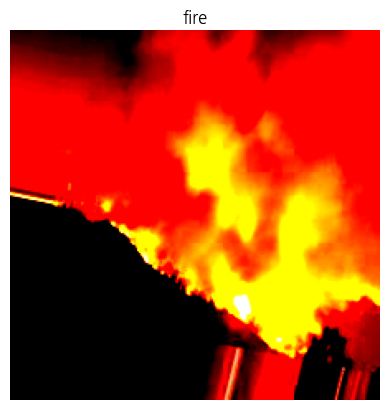

In [9]:
name_dict = {0 : 'fire', 1 : 'nofire', 2: 'smoke' , 3 : 'smokefire'}

INDEX = 20

a = DL.dataset[INDEX][0].permute(1,2,0)
plt.axis('off')
plt.title(name_dict[DL.dataset[INDEX][1]])
plt.imshow(a)
plt.show()


In [10]:
# GPU 사용 가능 여부 확인 
if torch.cuda.is_available():
    print('GPU')
    device = torch.device("cuda")
else:
    print('CPU')
    device = torch.device("cpu")


CPU


> > > 전이학습 모델 - Vgg19_bn


In [22]:
# 전이학습 모델 Vgg (weight 사용)
model = models.vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1).to(device)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True


In [23]:
# 마지막 레이어 (full connected layer) 교체 (클래스 4개)
num_features = model.classifier[0].in_features
model.classifier = nn.Linear(num_features, 4)

# 손실 함수와 옵티마이저 정의
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)


In [24]:
trainDL.dataset[0][0].shape


torch.Size([3, 224, 224])

In [25]:
EPOCH = 100
SAVE_PATH = r'D:\yunho\pj_14_final\vgg_model'

result=training(trainDL, validDL, model,
                 model_type = 'multiclass', optimizer = optimizer,
                 epoch = EPOCH, endurance_cnt = 7, view_epoch = 1,
                 num_classes = 4, SAVE_PATH = SAVE_PATH)


[EPOCH] : [1] 모델을 저장합니다.
[Loss : 1/100] Train : 0.4356, Test : 0.4144
[Score  : 1/100] Train : 0.8417, Test : 0.8644
[EPOCH] : [2] 모델을 저장합니다.
[Loss : 2/100] Train : 0.1699, Test : 0.4116
[Score  : 2/100] Train : 0.9366, Test : 0.8758
[Loss : 3/100] Train : 0.1024, Test : 0.4199
[Score  : 3/100] Train : 0.9622, Test : 0.8913
[Loss : 4/100] Train : 0.0977, Test : 0.6061
[Score  : 4/100] Train : 0.9642, Test : 0.8710
[Loss : 5/100] Train : 0.0765, Test : 0.5092
[Score  : 5/100] Train : 0.9721, Test : 0.8895
[Loss : 6/100] Train : 0.0546, Test : 0.5536
[Score  : 6/100] Train : 0.9805, Test : 0.8867
[Loss : 7/100] Train : 0.0439, Test : 0.5600
[Score  : 7/100] Train : 0.9841, Test : 0.8920
[Loss : 8/100] Train : 0.0486, Test : 0.6530
[Score  : 8/100] Train : 0.9830, Test : 0.8834
[Loss] 값의 개선이 이루어지지 않아 [9] EPOCH에서 학습을 종료합니다.


<function matplotlib.pyplot.show(close=None, block=None)>

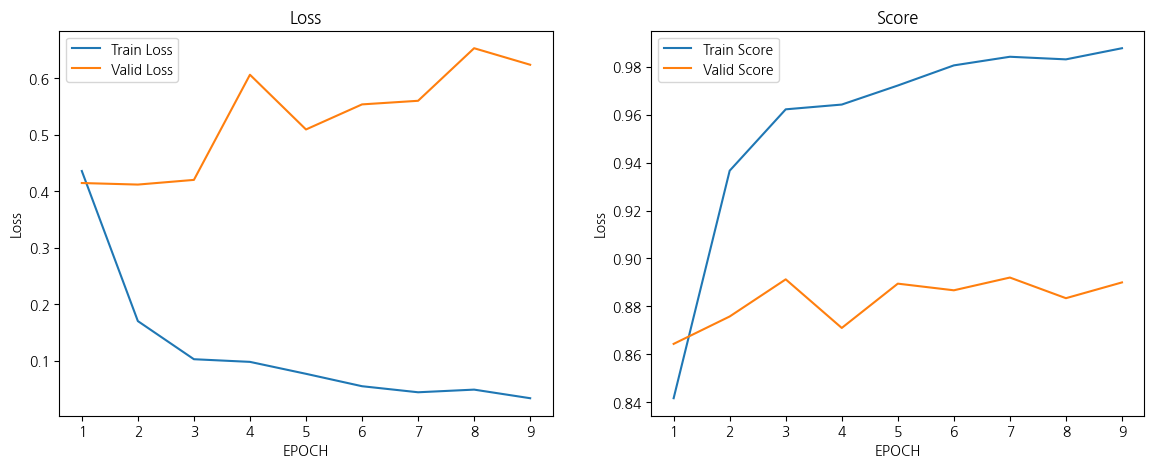

In [26]:
DrawPlot(result)
plt.show


In [11]:
MODEL_PATH=r'C:\WorkSpace\LocalData\pj_14_final\vgg_model\best_model_epoch_2.pth'


In [12]:
best_model = models.vgg19_bn(weights=VGG19_BN_Weights.IMAGENET1K_V1).to(device)

best_model.classifier = nn.Linear(in_features=25088, out_features=4)

best_model.load_state_dict(torch.load(MODEL_PATH, weights_only=True, map_location=torch.device('cpu')))


<All keys matched successfully>

In [13]:
input_data = []
target_data = []
for i, j in validDL:
    input_data.append(i)
    target_data.append(j)
    break


In [14]:
input_data[0].shape


torch.Size([32, 3, 224, 224])

In [15]:
pred_value = torch.argmax(best_model(input_data[0]), dim=1)
pred_value


tensor([1, 0, 0, 3, 0, 0, 2, 0, 2, 1, 1, 3, 3, 2, 3, 2, 1, 1, 3, 3, 0, 2, 0, 3,
        1, 0, 3, 3, 3, 3, 0, 3])

In [16]:
{i : DS.classes[i] for i in range(len(DS.classes))}


{0: 'fire', 1: 'nofire', 2: 'smoke', 3: 'smokefire'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


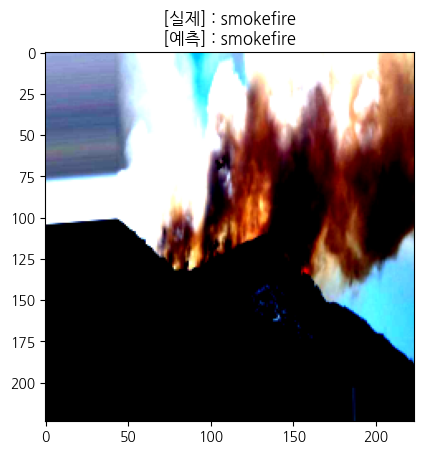

In [18]:
INDEX = 3 # 배치 사이즈 범위 내의 값

name_dict = {i : DS.classes[i] for i in range(len(DS.classes))}
pred_name = name_dict[pred_value[INDEX].item()]
real_name = name_dict[target_data[0][INDEX].item()]
plt.imshow(input_data[0][INDEX].permute(1,2,0))
plt.title(f'[실제] : {real_name}\n[예측] : {pred_name}')
plt.show()


In [ ]:
test_target=[i[0] for i in testDL.dataset]
test_label=[i[1] for i in testDL.dataset]
